In [474]:
# Preliminary Data Extraction

# Import libraries
from msc_code.scripts.notebook_setup import *

In [475]:
# Define input path
ip = "/".join([RAW_DATA_DIR, "data_extraction"])

# Define output path
op = "/".join([PROC_DATA_DIR, "data_extraction"])

# Define case data path
case_data_path = os.path.join(ip, "case_report_data_extraction_end.xlsx")
paper_data_path = os.path.join(ip, "data_extraction_end.xlsx")

# Define output path
output_path = os.path.join(OUTPUT_DIR, "reports", "data_extraction")

# Define figures path
figures_path = os.path.join(OUTPUT_DIR, "reports", "data_extraction", "figures")

# Define tables_folder
tables_folder = os.path.join(OUTPUT_DIR, "reports", "data_extraction", "tables")

In [476]:
# Import case data
case_df = pd.read_excel(case_data_path)
# Import paper data
paper_df = pd.read_excel(paper_data_path)

In [477]:
# Filter out Study_ID == 3
case_df = case_df[case_df['Study_ID'] != 3]
paper_df = paper_df[paper_df['Study_ID'] != 3]

## Paper Data

In [478]:
paper_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 1 to 104
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Study_ID               104 non-null    int64  
 1   First_Author           68 non-null     object 
 2   Publication_Year       104 non-null    int64  
 3   Authors                0 non-null      float64
 4   Publication_Title      1 non-null      object 
 5   Title                  104 non-null    object 
 6   Study_Design           76 non-null     object 
 7   Study_Setting          64 non-null     object 
 8   Study_Location         65 non-null     object 
 9   DOI                    50 non-null     object 
 10  Data_Extracted         104 non-null    object 
 11  Bibliography_Searched  0 non-null      float64
 12  Exclude                0 non-null      float64
 13  Notes                  0 non-null      float64
dtypes: float64(4), int64(2), object(8)
memory usage: 12.2+ KB


In [479]:
# Filter out papers where data extraction not complete
paper_df = paper_df[paper_df['Data_Extracted'] == 'Y']

paper_df.head()

,Study_ID,First_Author,Publication_Year,Authors,Publication_Title,Title,Study_Design,Study_Setting,Study_Location,DOI,Data_Extracted,Bibliography_Searched,Exclude,Notes
1,39,"Tanigawa, K.",1993,NaN,Chinese Medical Journal,Endoscopic Removal Of Foreign Bodies In The Me...,Case Report,NaN,Japan,NaN,Y,NaN,NaN,NaN
3,51,"Losanoff, J.E.",1996,NaN,NaN,Gastrointestinal 'Crosses'. A New Shade From A...,Case Series,University Hospital in Bulgaria,Bulgaria,10.1001/archsurg.1996.01430140056015,Y,NaN,NaN,NaN
4,54,"Losanoff, J.E.",1997,NaN,NaN,"Oesophageal ""Cross""--A Sinister Foreign Body",Case Report,University Hospital in Bulgaria,Bulgaria,10.1136/emj.14.1.54,Y,NaN,NaN,NaN
5,60,"Goldman, R.D.",1998,NaN,NaN,A Bizarre Bezoar: Case Report And Review Of Th...,Case Report,Paediatric Surgery in Israel,Israel,10.1007/s003830050492,Y,NaN,NaN,NaN
6,61,"Csaky, G.",1998,NaN,NaN,Laparoscopic Removal Of A Foreign Body From Th...,Case Report,County Hospitak,Hungary,NaN,Y,NaN,NaN,NaN


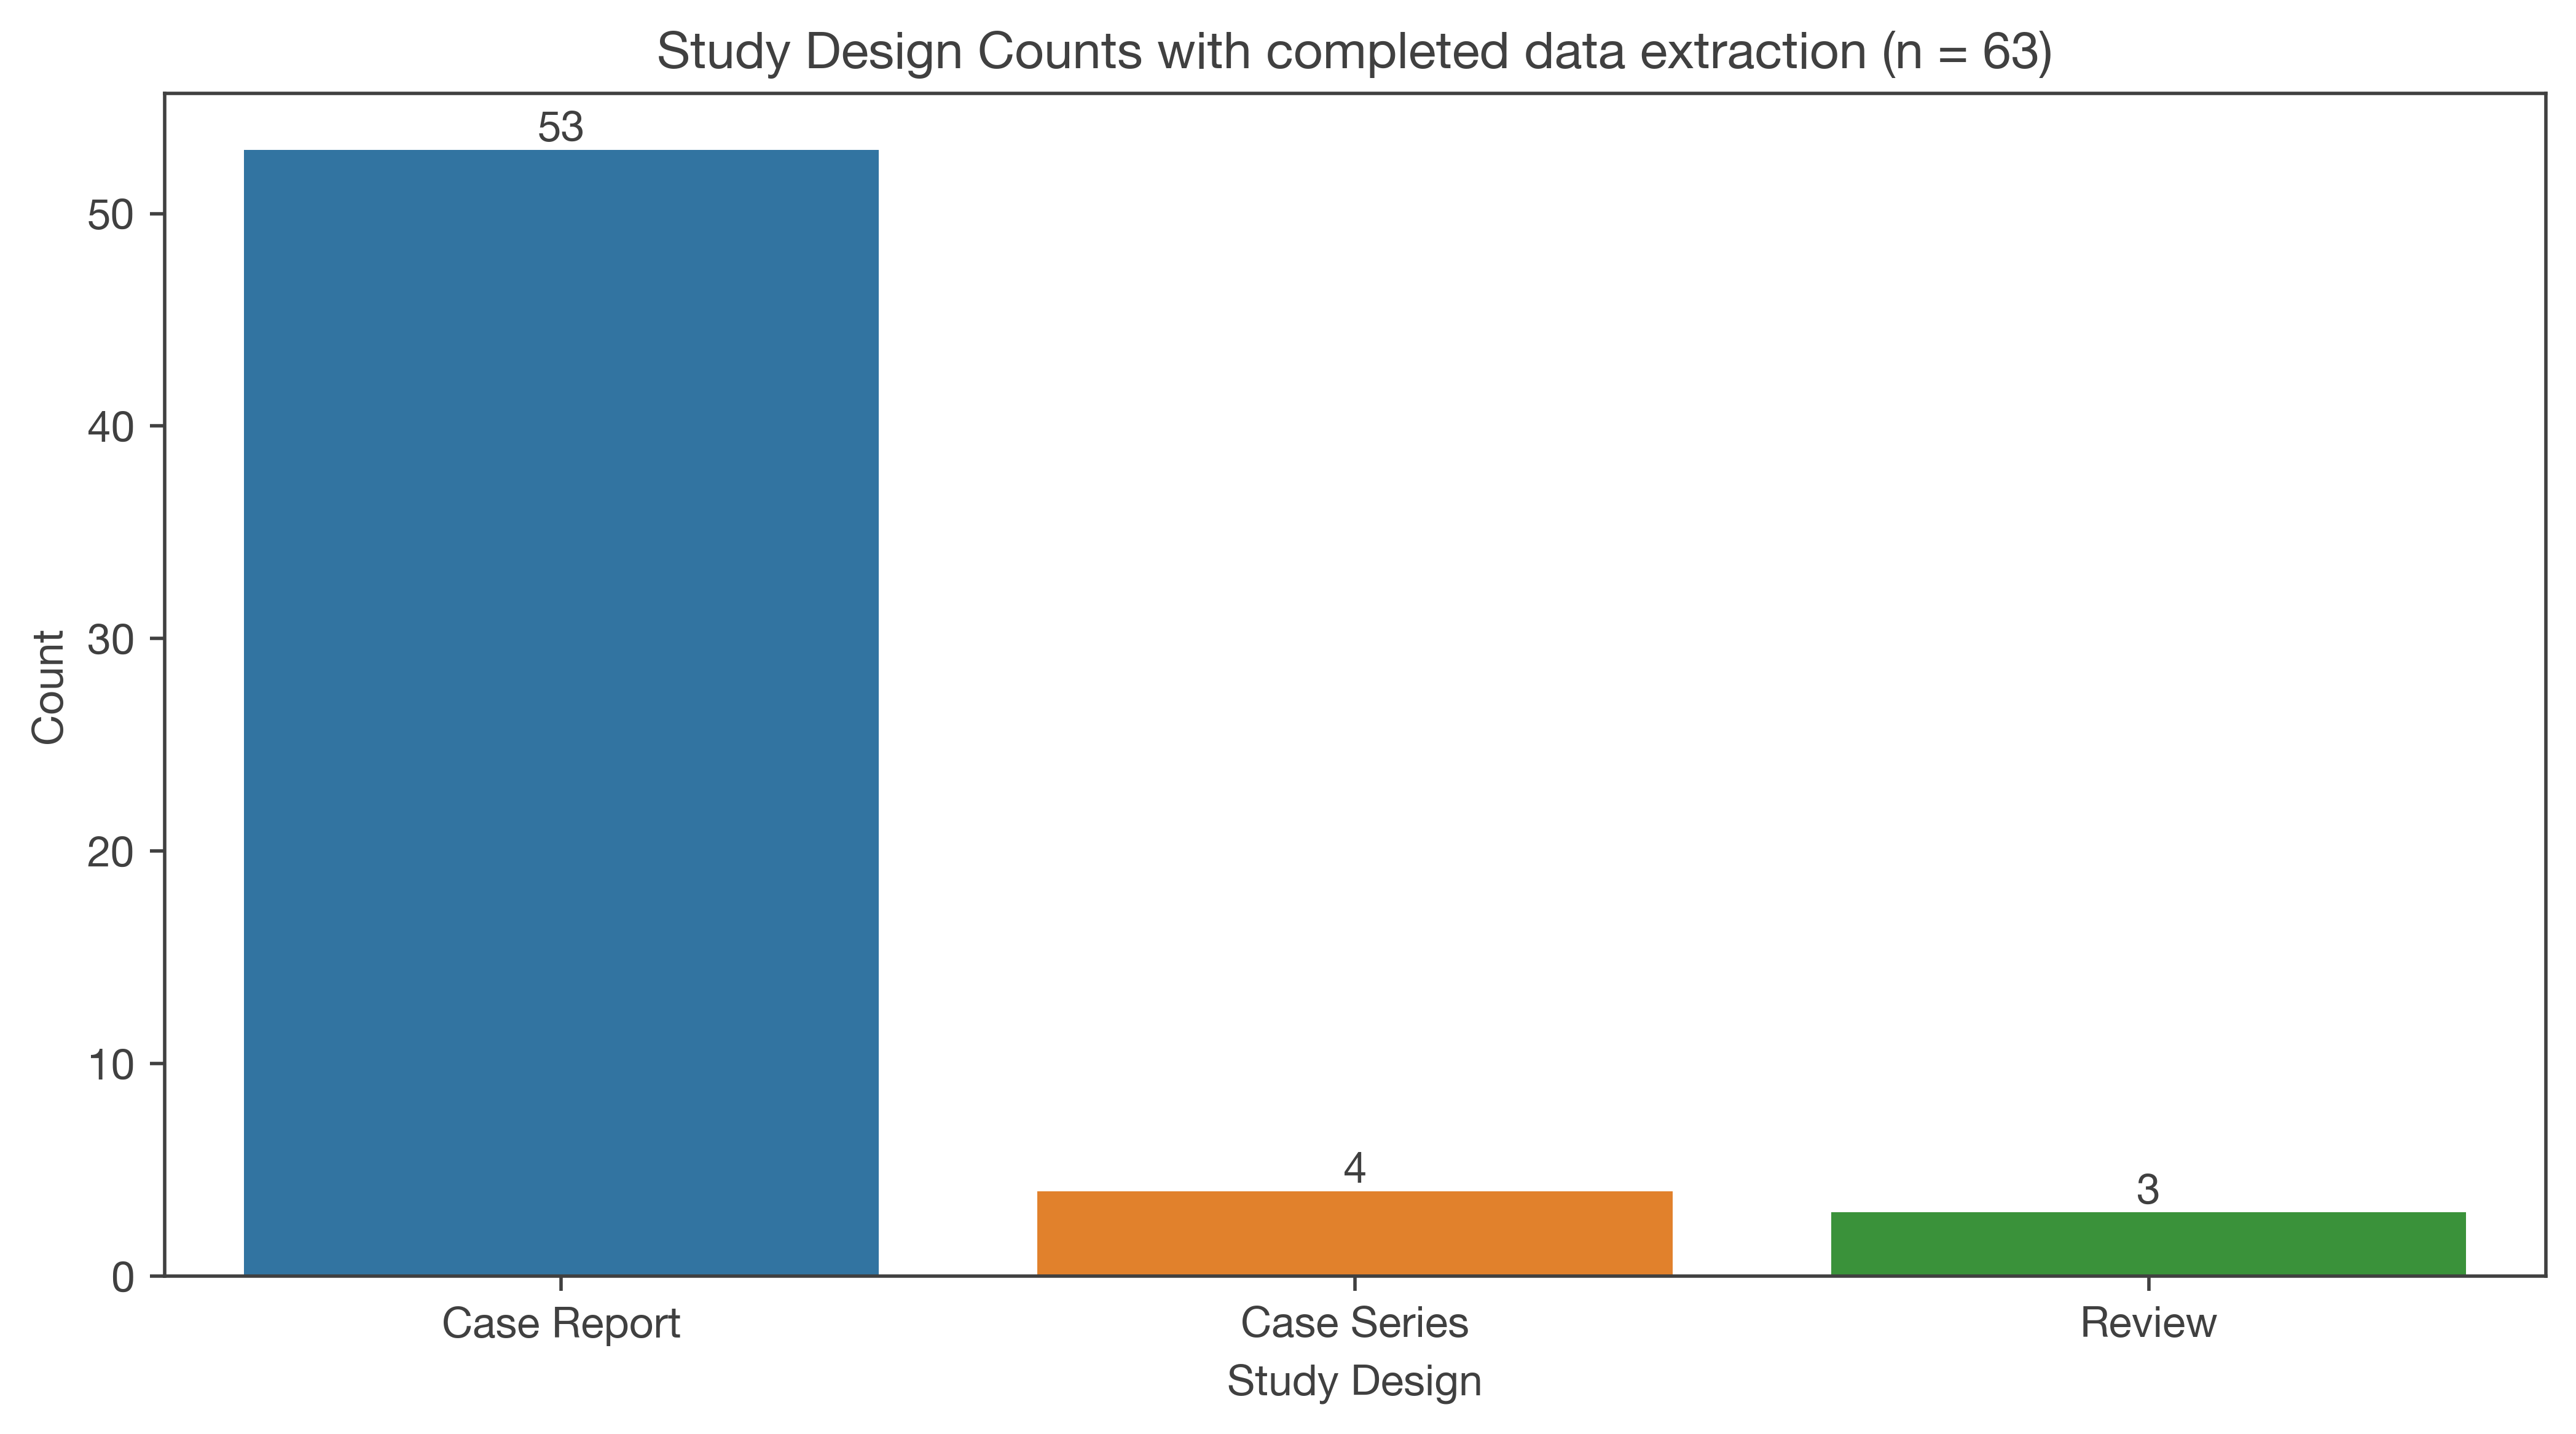

In [480]:
plot_data = paper_df['Study_Design'].value_counts().reset_index()
plot_data.columns = ['Study Design', 'Count']

plt.figure(figsize=(10,5))
ax = sns.barplot(data=plot_data,
                 x='Study Design',
                 y='Count')

# Set title and labels
ax.set(title=f'Study Design Counts with completed data extraction (n = {len(paper_df)})', xlabel='Study Design', ylabel='Count')

# Add labels to the top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')
    
plot_path = os.path.join(figures_path, "study_design_plot.png")
plt.savefig(plot_path)
plt.show()
plt.close()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


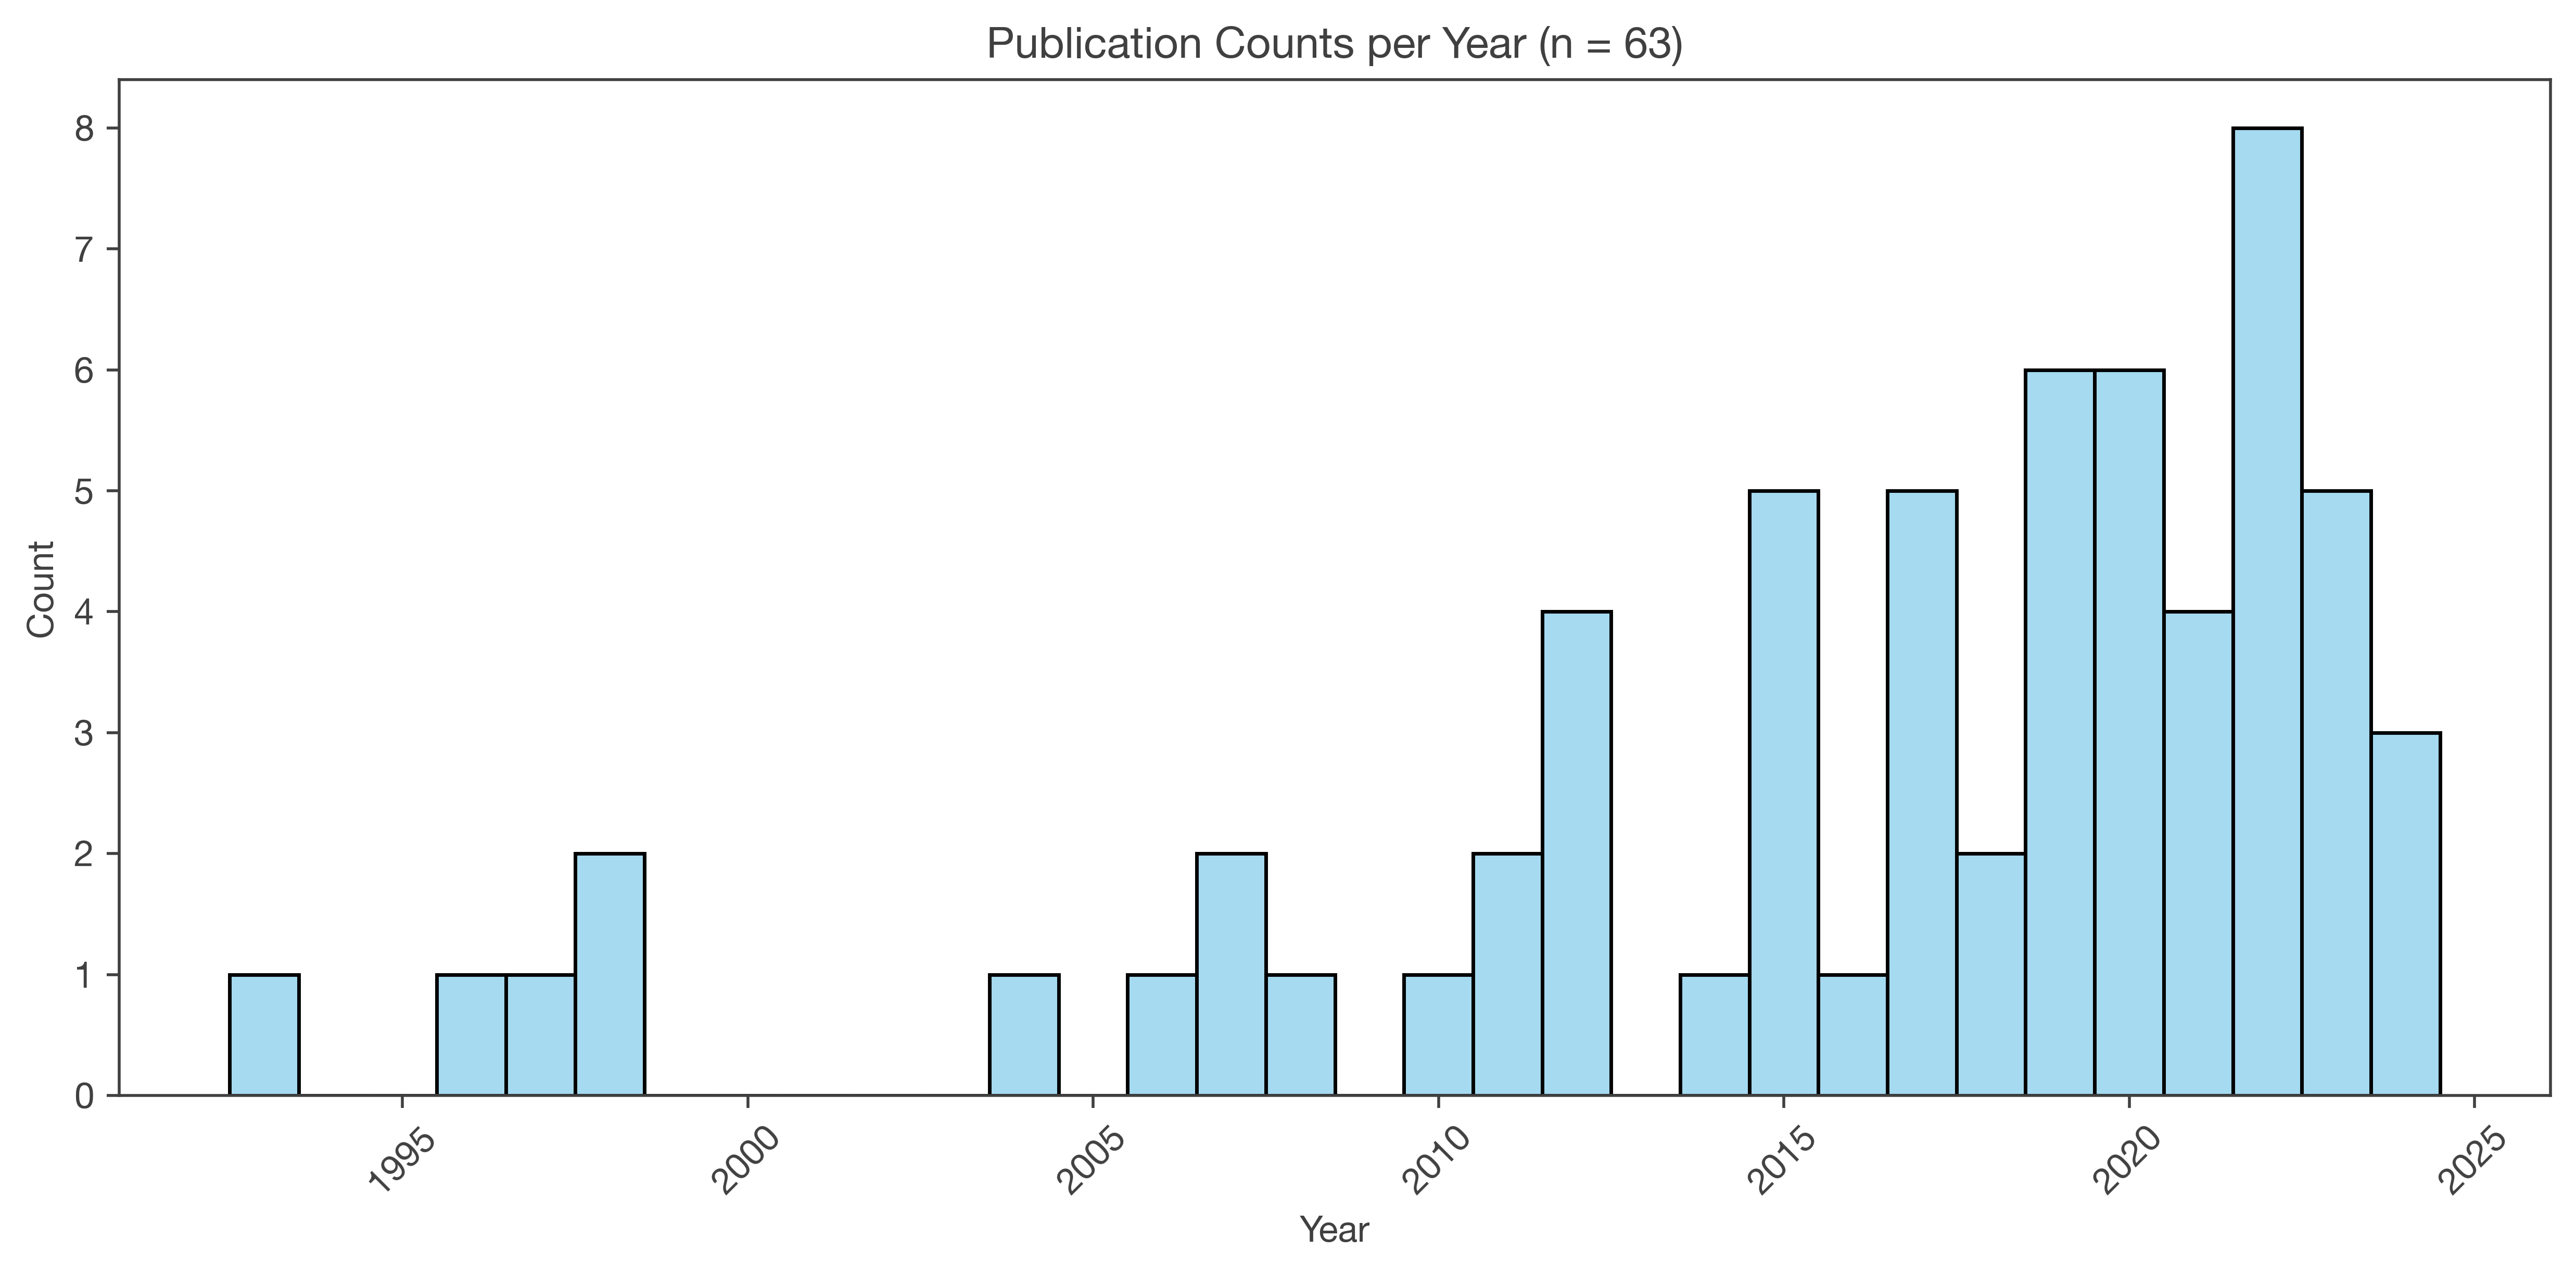

In [481]:
plot_data = paper_df.copy()

plt.figure(figsize=(10,5))
ax = sns.histplot(
    data=plot_data,
    x='Publication_Year',
    bins='auto',
    color='skyblue',
    discrete=True
)

# Set y-axis ticks to increment by 1
y_max = ax.get_ylim()[1]
ax.set_yticks(np.arange(0, int(y_max) + 1, 1))

# Titles and labels
ax.set(title=f'Publication Counts per Year (n = {len(paper_df)})')
plt.xlabel('Year')
plt.ylabel('Count')

plt.xticks(rotation=45)  # Rotate x-ticks if needed for readability
plt.tight_layout()
plot_path = "/".join([figures_path, "publications_per_year_plot.png"])
plt.savefig(plot_path)
plt.show()


In [482]:
case_df['Study_ID'] = case_df['Study_ID'].astype('int')

# Patient_ID
case_df['Patient_ID'] = case_df['Patient_ID'].astype('str')
# Check Patient_ID is unique
print(f"All Patient_ID's are unique?: {case_df['Patient_ID'].is_unique}")

# Create dataframe of duplicate patient Ids
duplicates = case_df[case_df['Patient_ID'].duplicated(keep=False)]
print(duplicates)

All Patient_ID's are unique?: True
Empty DataFrame
Columns: [Study_ID, Patient_ID, Age_Yrs, Gender, Is_Prisoner, Is_Psych_Inpat, Is_Displaced_Person, Under_Influence_Alcohol, Psych_Hx, Severe_Disability_Hx, Previous_Ingestions, Motivation_Intent_To_Harm, Motivation_Protest, Motivation_Psychiatric, Motivation_Psychosocial, Motivation_Unknown, Motivation_Other, Motivation_Other_Long, Object_Button_Battery, Object_Magnet, Object_Long, Object_Diameter_Large, Object_Sharp, Object_Multiple, Object_Other_Long, Outcome_Endoscopy, Outcome_Surgery, Outcome_Death, Outcome_Injury_Needing_Intervention, Outcome_Perforation, Outcome_Obstruction, Outcome_Other, Outcome_Other_Long, Comments]
Index: []

[0 rows x 34 columns]


In [483]:
# Calculate number of cases per paper
case_counts = case_df.groupby('Study_ID')['Patient_ID'].count()

# Map to paper_data, creating 'Case_Count' column
paper_df['Case_Count'] = paper_df['Study_ID'].map(case_counts)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


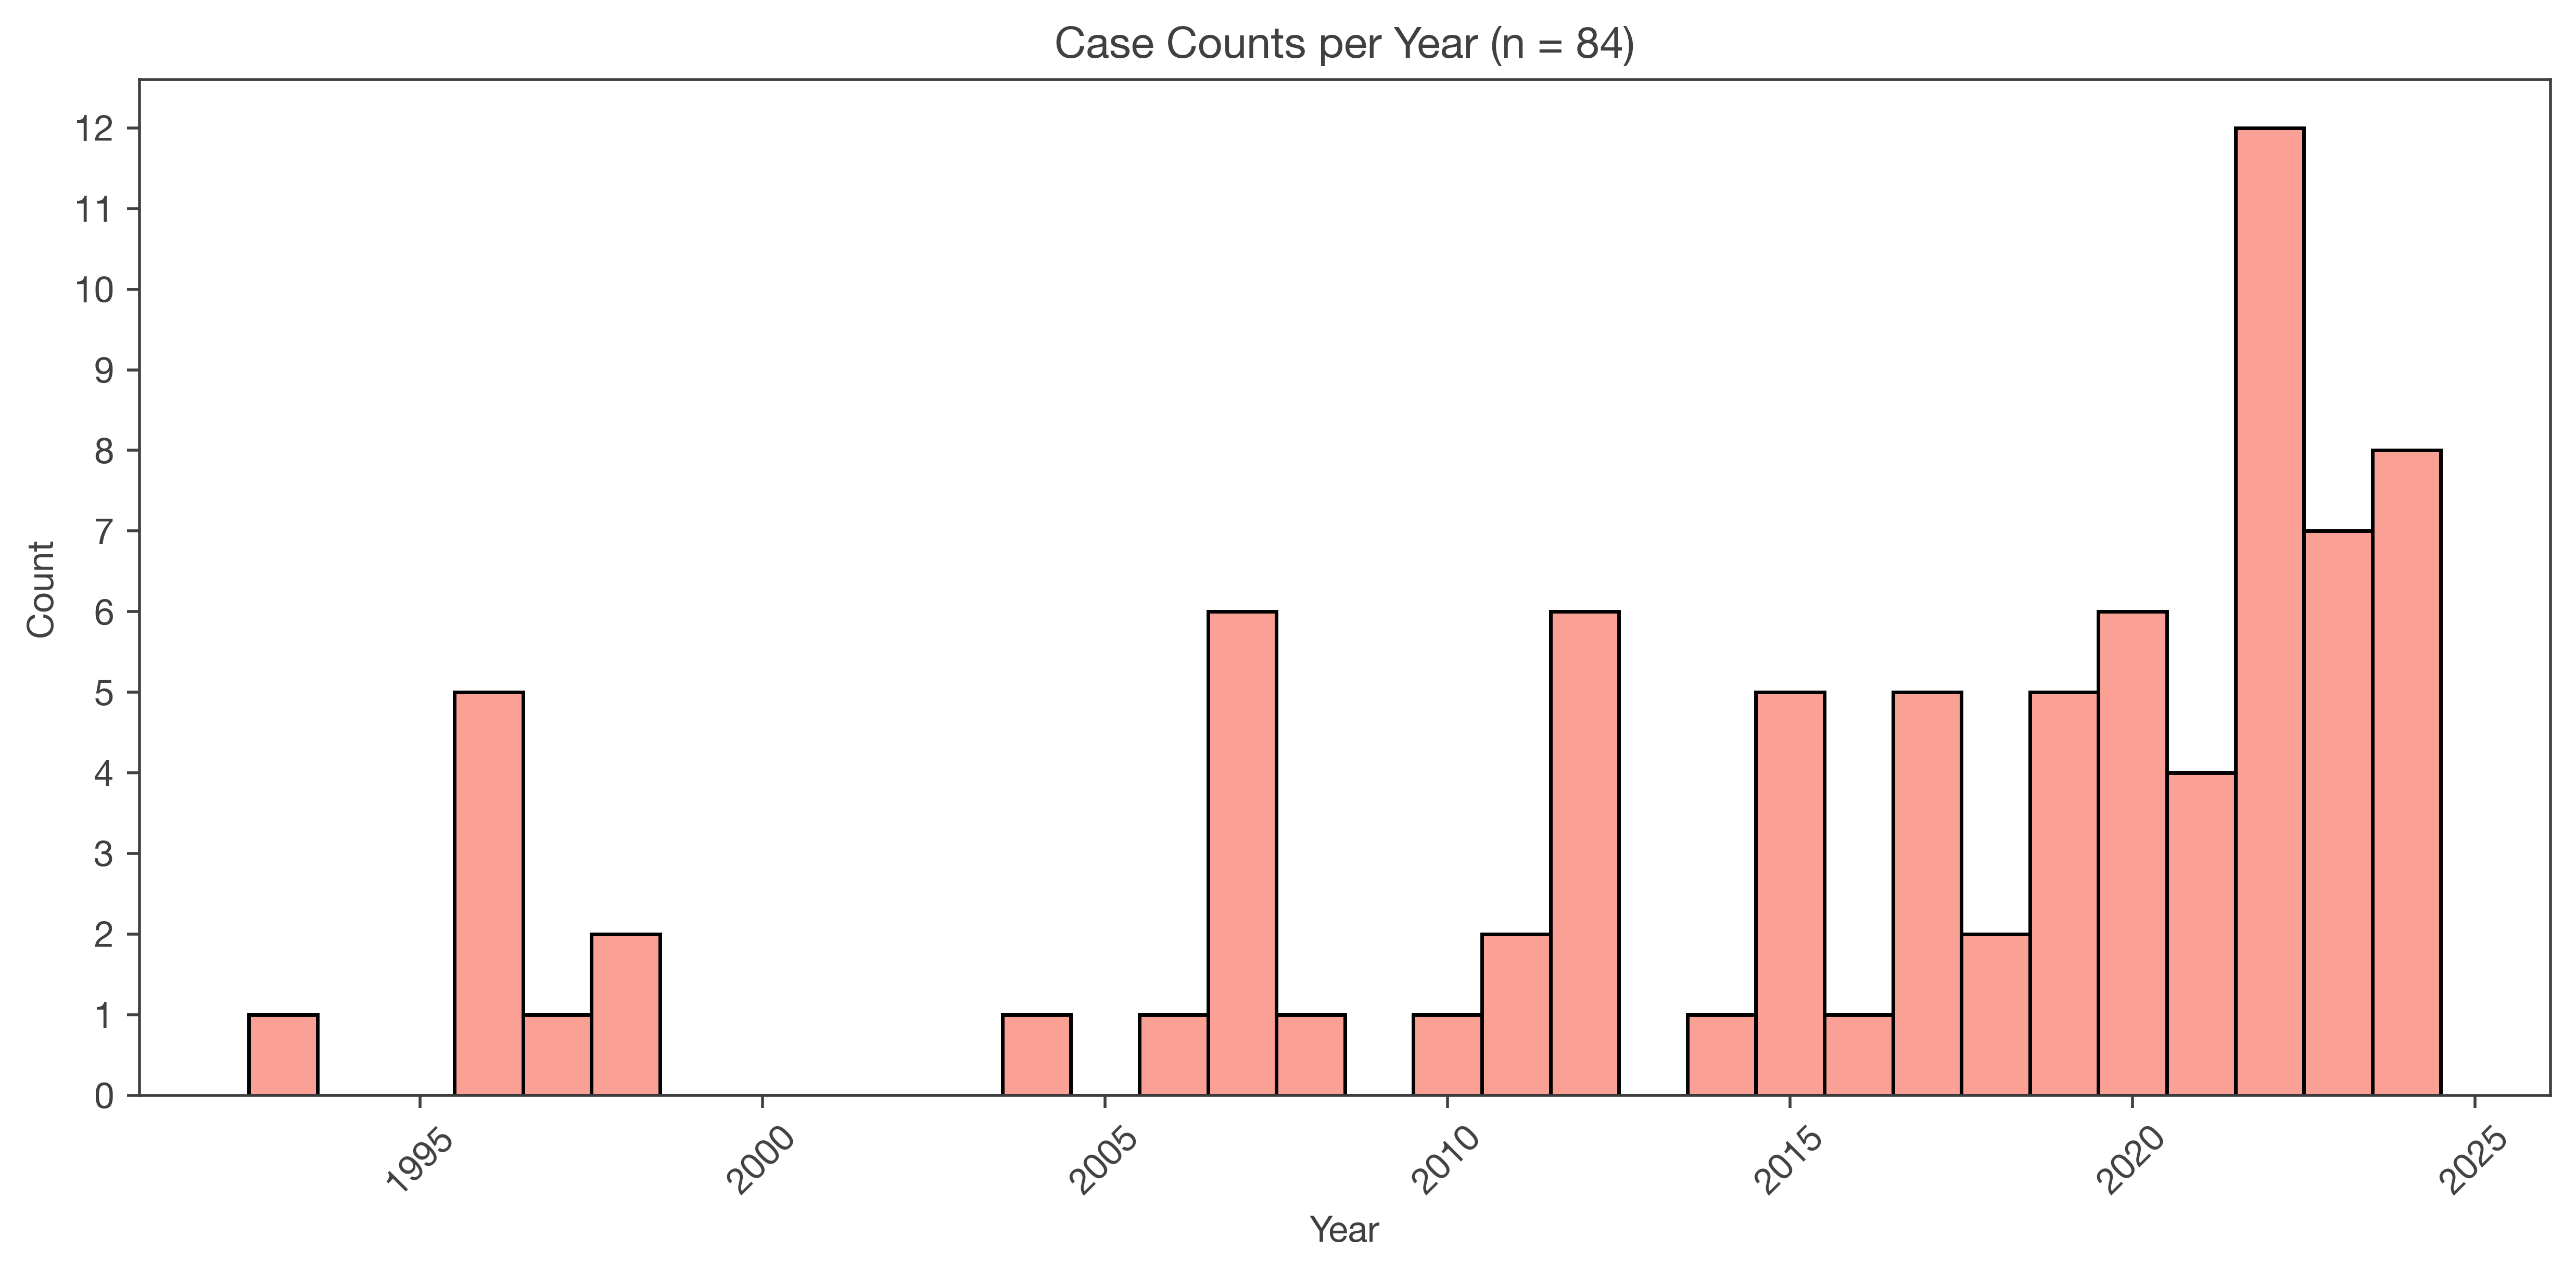

In [484]:
# Filter only extracted papers
plot_data = paper_df.copy()

# Plot histogram
plt.figure(figsize=(10, 5))
ax = sns.histplot(
    data=plot_data,
    x='Publication_Year',
    weights='Case_Count',
    bins='auto',  # Let Seaborn automatically determine the bins
    color='salmon',
    discrete=True
)

# Set y-axis ticks to increment by 1
y_max = ax.get_ylim()[1]
ax.set_yticks(np.arange(0, int(y_max) + 1, 1))

# Titles and labels
ax.set(title=f'Case Counts per Year (n = {len(case_df)})')
plt.xlabel('Year')
plt.ylabel('Count')

plt.xticks(rotation=45)  # Rotate x-ticks if needed for readability
plt.tight_layout()
plot_path = "/".join([figures_path, "cases_per_year_plot.png"])
plt.savefig(plot_path)
plt.show()

## Case Data

In [485]:
# View case_df column headers.
case_df.columns

Index(['Study_ID', 'Patient_ID', 'Age_Yrs', 'Gender', 'Is_Prisoner',
       'Is_Psych_Inpat', 'Is_Displaced_Person', 'Under_Influence_Alcohol',
       'Psych_Hx', 'Severe_Disability_Hx', 'Previous_Ingestions',
       'Motivation_Intent_To_Harm', 'Motivation_Protest',
       'Motivation_Psychiatric', 'Motivation_Psychosocial',
       'Motivation_Unknown', 'Motivation_Other', 'Motivation_Other_Long',
       'Object_Button_Battery', 'Object_Magnet', 'Object_Long',
       'Object_Diameter_Large', 'Object_Sharp', 'Object_Multiple',
       'Object_Other_Long', 'Outcome_Endoscopy', 'Outcome_Surgery',
       'Outcome_Death', 'Outcome_Injury_Needing_Intervention',
       'Outcome_Perforation', 'Outcome_Obstruction', 'Outcome_Other',
       'Outcome_Other_Long', 'Comments'],
      dtype='object')

In [486]:
# Create additional columns 
case_df['Object_Long_Sharp'] = case_df.apply(
    lambda row: 'Y' if row['Object_Long'] == 'Y' and row['Object_Sharp'] == 'Y' else 'N',
    axis=1
)

# Create Object_Short
case_df['Object_Short'] = case_df.apply(
    lambda row: 'Y' if row['Object_Long'] == 'N' else 'N',
    axis=1
)

# Create Object_Short_Sharp
case_df['Object_Short_Sharp'] = case_df.apply(
    lambda row: 'Y' if row['Object_Short'] == 'Y' and row['Object_Sharp'] == 'Y' else 'N',
    axis=1
)

# Create additional columns 
case_df['Outcome_Conservative'] = case_df.apply(
    lambda row: 'Y' if row['Outcome_Surgery'] != 'Y' and row['Outcome_Endoscopy'] != 'Y' else 'N',
    axis=1
)
# Create Outcome Endoscopy_Surgery Column
case_df['Outcome_Endoscopy_Surgery'] = case_df.apply(
    lambda row: 'Y' if row['Outcome_Surgery'] == 'Y' and row['Outcome_Endoscopy'] == 'Y' else 'N',
    axis=1
)

# Create Motivation_Other_Psych_Hx
# Create additional columns 
case_df['Motivation_Other_Psych_Hx'] = case_df.apply(
    lambda row: 'Y' if row['Motivation_Other'] == 'Y' and row['Psych_Hx'] == 'Y' else 'N',
    axis=1
)

# Create Motivation_Other_Severe_Disability_Hx
case_df['Motivation_Other_Severe_Disability_Hx'] = case_df.apply(
    lambda row: 'Y' if row['Motivation_Other'] == 'Y' and row['Severe_Disability_Hx'] == 'Y' else 'N',
    axis=1
)


In [487]:
# motivation_count_cols = ['Motivation_Intent_To_Harm',
# 'Motivation_Protest',
# 'Motivation_Psychiatric',
# 'Motivation_Other',
# 'Motivation_Other_Psych_Hx',
# 'Motivation_Psychosocial']

# Count each 1 in each motivation_count column, excluding Motivation_Unknown
# case_df['Motivation_Count'] = case_df[motivation_count_cols].sum(axis=1)

In [488]:
# Free text cols
free_text_cols = ['Comments', 'Motivation_Other_Long', 'Object_Other_Long', 'Outcome_Other_Long']


# Define age_gender cols
age_gender_cols = ['Age_Yrs', 'Gender']

# Define Population Variable cols
population_cols = ['Is_Prisoner', 'Is_Psych_Inpat', 
                   'Is_Displaced_Person', 'Under_Influence_Alcohol', 'Psych_Hx', 
                   'Severe_Disability_Hx', 'Previous_Ingestions']

# Define motivation varibale cols
motivation_cols = [col for col in case_df.columns if 'Motivation' in col and col not in free_text_cols]

# Define object variable cols
object_cols = [col for col in case_df.columns if 'Object' in col and col not in free_text_cols]

# Define outcome variable cols
outcome_cols = [col for col in case_df.columns if 'Outcome' in col and col not in free_text_cols]

# Non-binary cols
non_binary_cols = [
    'Study_ID',
    'Patient_ID',
    'Age_Yrs',
    'Gender',
    'Comments',
    'Motivation_Other_Long',
    'Object_Other_Long',
    'Outcome_Other_Long'
]

binary_cols = [
    col for col in population_cols + motivation_cols + object_cols + outcome_cols
    if col not in free_text_cols
]

# Convert 'Y', 'N' and 'UK' values to binary for better data handling. Leave 'UK' as blank.
# Define the mapping dictionary
binary_map = {'Y': 1, 'N': 0, 'UK': 0}

# Apply to all binary columns
case_df[binary_cols] = case_df[binary_cols].applymap(lambda x: binary_map.get(x, np.nan))

/var/folders/2z/pkyt34z93md62kmcdphb_kf00000gn/T/ipykernel_1722/786128210.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  case_df[binary_cols] = case_df[binary_cols].applymap(lambda x: binary_map.get(x, np.nan))


In [489]:
# Convert Study_ID to string.
case_df['Study_ID'] = case_df['Study_ID'].astype(str)

# Convert Patient_ID to string.
case_df['Study_ID'] = case_df['Study_ID'].astype(str)

# Handle UK values in Age_Yrs.
case_df['Age_Yrs'] = case_df['Age_Yrs'].replace('UK', np.nan).astype(float)

# Handle UK values in Gender and convert to categorical variable
case_df['Gender'] = case_df['Gender'].replace('UK', 'Unknown').astype('category')

In [490]:
# Create age summary
age_summary = case_df['Age_Yrs'].describe().reset_index()
age_summary.columns = ['Statistic', 'Age (Years)']

age_summary['Statistic'] = age_summary['Statistic'].str.capitalize()

latex_table = age_summary.to_latex(
    index=False,
    caption=None,
    label=None,
    float_format="%.1f",
    escape=True
)

# Wrap with a properly centered LaTeX table block
latex_wrapped = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Summary statistics for age in years.}}
\\label{{tab:age-summary}}
{latex_table}
\\end{{table}}
\\FloatBarrier
"""

# Write to file
table_path = os.path.join(tables_folder, "age_summary.tex")
with open(table_path, "w") as f:
    f.write(latex_wrapped)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


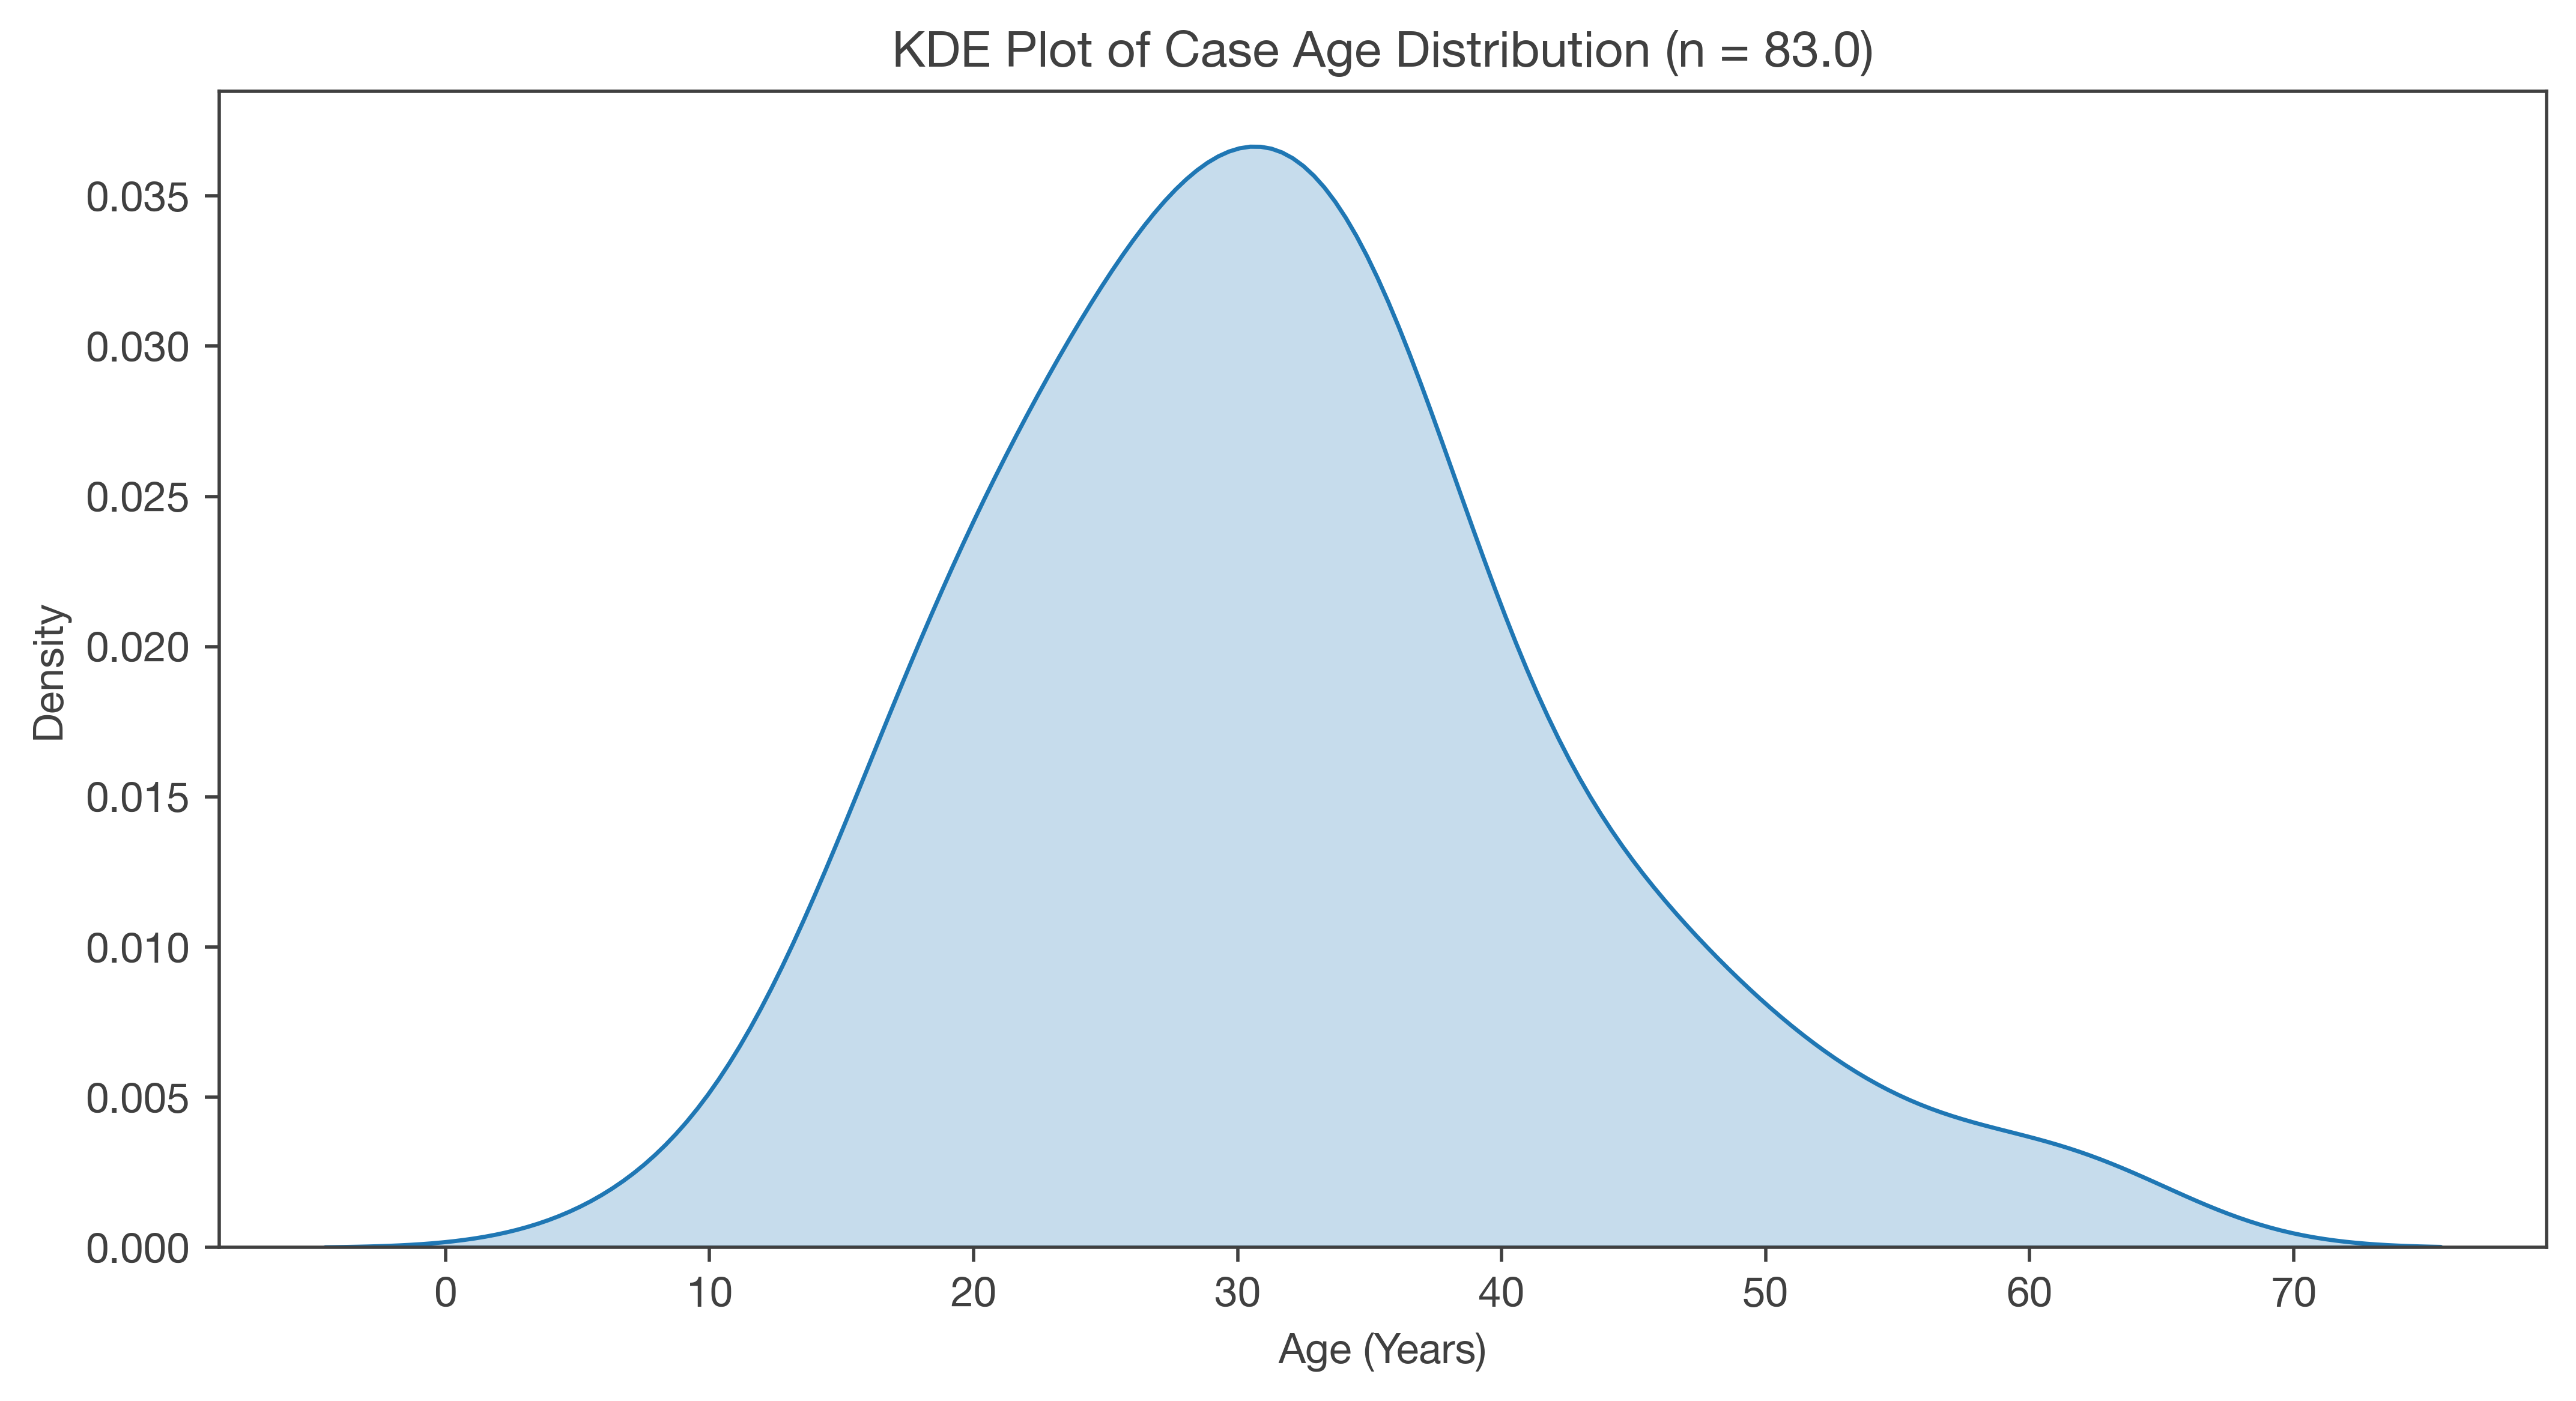

In [491]:
plot_data = case_df['Age_Yrs']

plt.figure(figsize=(10,5))
ax = sns.kdeplot(data=plot_data,
                 fill=True)

ax.set(title=f"KDE Plot of Case Age Distribution (n = {paper_df['Case_Count'].sum()})",
       xlabel='Age (Years)')

plot_path = os.path.join(figures_path, "kde_age_plot.png")
plt.savefig(plot_path)
plt.show()
plt.close()

In [492]:
gender_summary = case_df['Gender'].value_counts().reset_index()
gender_summary.columns = ['Gender', 'Count (N)']

gender_summary['Percentage (%)'] = (gender_summary['Count (N)'] / gender_summary['Count (N)'].sum() * 100)

latex_table = gender_summary.to_latex(
    index=False,
    caption=None,
    label=None,
    float_format="%.1f",
    escape=True
)

# Wrap with a properly centered LaTeX table block
latex_wrapped = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Counts and percentages of 1s in Gender Column (sorted descending)}}
\\label{{tab:gender-summary}}
{latex_table}
\\end{{table}}
\\FloatBarrier
"""

# Write to file
table_path = os.path.join(tables_folder, "gender_summary.tex")
with open(table_path, "w") as f:
    f.write(latex_wrapped)

gender_summary

,Gender,Count (N),Percentage (%)
0,Male,54,64.285714
1,Female,29,34.523810
2,Unknown,1,1.190476


In [493]:
import textwrap

# Define column groups
table_groups = {
    "population_summary": population_cols,
    "motivation_summary": motivation_cols,
    "object_summary": object_cols,
    "outcome_summary": outcome_cols,
}

# Output folder
tables_folder = os.path.join(output_path, "tables")
os.makedirs(tables_folder, exist_ok=True)

for name, cols in table_groups.items():
    df = case_df[cols].copy()

    # Count valid (non-NaN) values per column
    valid_n = df.notna().sum()

    # Count number of 1s per column (after dropping NaNs)
    counts = df.apply(lambda x: (x.dropna() == 1).sum())

    # Calculate percentages
    percentages = (counts / valid_n * 100).round(1)

    # Combine into summary table
    summary = pd.DataFrame({
        'Count (1s)': counts,
        'Valid N': valid_n,
        'Percentage (%)': percentages
    })

    # Clean variable names
    summary.index = summary.index.str.replace('_', ' ')

    # Sort by percentage descending
    summary = summary.sort_values(by='Percentage (%)', ascending=False)

    # Convert DataFrame to LaTeX tabular (no full table wrapper)
    latex_tabular = summary.to_latex(
        index=True,
        caption=None,
        label=None,
        float_format="%.1f",
        escape=True
    )

    # Remove any accidental caption or label
    latex_tabular = "\n".join(
        line for line in latex_tabular.splitlines()
        if not line.strip().startswith("\\caption") and not line.strip().startswith("\\label")
    )

    # Wrap full LaTeX table manually
    latex_full_table = textwrap.dedent(f"""\
        \\begin{{table}}[H]
        \\centering
        \\caption{{Counts and percentages of 1s for {name.replace('_', ' ')} (sorted descending by percentage).}}
        {latex_tabular}
        \\label{{tab:{name}}}
        \\end{{table}}
        \\FloatBarrier
    """)

    # Strip leading/trailing blank lines
    latex_full_table = latex_full_table.strip()

    # Write to file
    table_path = os.path.join(tables_folder, f"{name}.tex")
    with open(table_path, "w") as f:
        f.write(latex_full_table)

    print(f"✅ Wrote: {table_path}")

✅ Wrote: /Users/jackgedge/msc_dissertation/output/reports/data_extraction/tables/population_summary.tex
✅ Wrote: /Users/jackgedge/msc_dissertation/output/reports/data_extraction/tables/motivation_summary.tex
✅ Wrote: /Users/jackgedge/msc_dissertation/output/reports/data_extraction/tables/object_summary.tex
✅ Wrote: /Users/jackgedge/msc_dissertation/output/reports/data_extraction/tables/outcome_summary.tex


In [494]:
# Filter the DataFrame for relevant rows
table_data = case_df[case_df['Motivation_Other'] == 1]

# Select and reset index
motivation_other_long_df = table_data[['Patient_ID', 'Motivation_Other_Long']].reset_index(drop=True)

# Path to save the table
table_path = os.path.join(tables_folder, "motivation_other_long_table.tex")

# Generate LaTeX table string with fixed-width columns
latex_table = motivation_other_long_df.to_latex(
    index=False,
    caption=None,
    label=None,
    column_format='p{3cm}p{12cm}',  # Set column widths for wrapping
    escape=True
)

# Extract header and content from LaTeX table string
table_lines = latex_table.splitlines()
table_header = "Patient\\ ID & Free Text Motivation\\\\"  # The column headers
table_content = "\n".join(table_lines[4:-2])  # The table rows (skip top and bottom lines)

# Wrap in LaTeX table environment with better formatting
latex_wrapped = f"""
\\begin{{table}}[H]
\\centering
\\renewcommand{{\\arraystretch}}{{1.2}}
\\caption{{List of comments made during data extraction in Motivation\\_Other\\_Long where Motivation\\_Other marked 'Y'.}}
\\label{{tab:motivation-other-summary}}
\\begin{{tabular}}{{p{{3cm}}p{{12cm}}}}
\\toprule
{table_header}
\\midrule
{table_content}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
\\FloatBarrier
"""

# Save the LaTeX file
with open(table_path, "w") as f:
    f.write(latex_wrapped)

print(f"✅ Wrote: {table_path}")

# Show the DataFrame as confirmation
motivation_other_long_df

✅ Wrote: /Users/jackgedge/msc_dissertation/output/reports/data_extraction/tables/motivation_other_long_table.tex


,Patient_ID,Motivation_Other_Long
0,113-001,"""Reported that thermometer ingestion and suici..."
1,168-001,"""Foreign body ingested in police custody to co..."
2,217-001,Smuggling
3,238-001,"""A 29-year-old mentally retarded female patien..."
4,260-001,"""history of cerebral palsy and self-destructiv..."
5,328-001,"""PICA"", ""anxiety and an empty prescription for..."
6,349-001,"""adjustment disorder who developed a gastrocol..."
7,414-001,"Smuggling - ""Patient intentionally ingested a ..."


In [495]:
# Filter the DataFrame for relevant rows
table_data = case_df.copy()

# Select and reset index
object_other_long_df = table_data[['Patient_ID', 'Object_Other_Long']].reset_index(drop=True)

# Path to save the table
table_path = os.path.join(tables_folder, "object_other_long_table.tex")

# Generate LaTeX table string with fixed-width columns
latex_table = object_other_long_df.to_latex(
    index=False,
    caption=None,
    label=None,
    column_format='p{3cm}p{12cm}',  # Set column widths for wrapping
    escape=True
)

# Extract header and content from LaTeX table string
table_lines = latex_table.splitlines()
table_header = "Patient\\ ID & Free Text Object\\\\"  # The column headers
table_content = "\n".join(table_lines[4:-2])  # The table rows (skip top and bottom lines)

# Wrap in LaTeX table environment with better formatting
latex_wrapped = f"""
\\begin{{table}}[H]
\\centering
\\renewcommand{{\\arraystretch}}{{1.2}}
\\caption{{List of comments made during data extraction in Object\\_Other\\_Long.}}
\\label{{tab:object-other-summary}}
\\begin{{tabular}}{{p{{3cm}}p{{12cm}}}}
\\toprule
{table_header}
\\midrule
{table_content}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
\\FloatBarrier
"""

# Save the LaTeX file
with open(table_path, "w") as f:
    f.write(latex_wrapped)

print(f"✅ Wrote: {table_path}")


✅ Wrote: /Users/jackgedge/msc_dissertation/output/reports/data_extraction/tables/object_other_long_table.tex


In [496]:
# Filter the DataFrame for relevant rows
table_data = case_df[case_df['Outcome_Other'] == 1]

# Select and reset index
outcome_other_long_df = table_data[['Patient_ID', 'Outcome_Other_Long']].reset_index(drop=True)

# Path to save the table
table_path = os.path.join(tables_folder, "outcome_other_long_table.tex")

# Generate LaTeX table string with fixed-width columns
latex_table = outcome_other_long_df.to_latex(
    index=False,
    caption=None,
    label=None,
    column_format='p{3cm}p{12cm}',  # Set column widths for wrapping
    escape=True
)

# Extract header and content from LaTeX table string
table_lines = latex_table.splitlines()
table_header = "Patient\\ ID & Free Text \\\\"  # The column headers
table_content = "\n".join(table_lines[4:-2])  # The table rows (skip top and bottom lines)

# Wrap in LaTeX table environment with better formatting
latex_wrapped = f"""
\\begin{{table}}[H]
\\centering
\\renewcommand{{\\arraystretch}}{{1.2}}
\\caption{{List of comments made during data extraction where Outcome\\_Other marked 'Y'.}}
\\label{{tab:outcome-other-summary}}
\\begin{{tabular}}{{p{{3cm}}p{{12cm}}}}
\\toprule
{table_header}
\\midrule
{table_content}
\\bottomrule
\\end{{tabular}}
\\end{{table}}
\\FloatBarrier
"""

# Save the LaTeX file
with open(table_path, "w") as f:
    f.write(latex_wrapped)

print(f"✅ Wrote: {table_path}")

# Show the DataFrame as confirmation
outcome_other_long_df

✅ Wrote: /Users/jackgedge/msc_dissertation/output/reports/data_extraction/tables/outcome_other_long_table.tex


,Patient_ID,Outcome_Other_Long
0,39-001,"""Fluroscopy"""
1,61-001,Interintestinal adhesions
2,85-001,"""lodged near the ileocecal valve and an inflam..."
3,99-001,"""Subsequent post-mortem confirmed a mediastina..."
4,113-001,"""Thermometer in Mediastinum"""
5,148-001,"""a median sternotomy was performed and pericar..."
6,168-001,"""presence of an ulcer in the angular part of t..."
7,214-001,"Severe antral erosion is observed, likely rela..."
8,261-001,"""complicated by respiratory failure requiring ..."
9,273-001,"""pneumoperitoneum and free intra-abdominal fluid"""


/opt/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


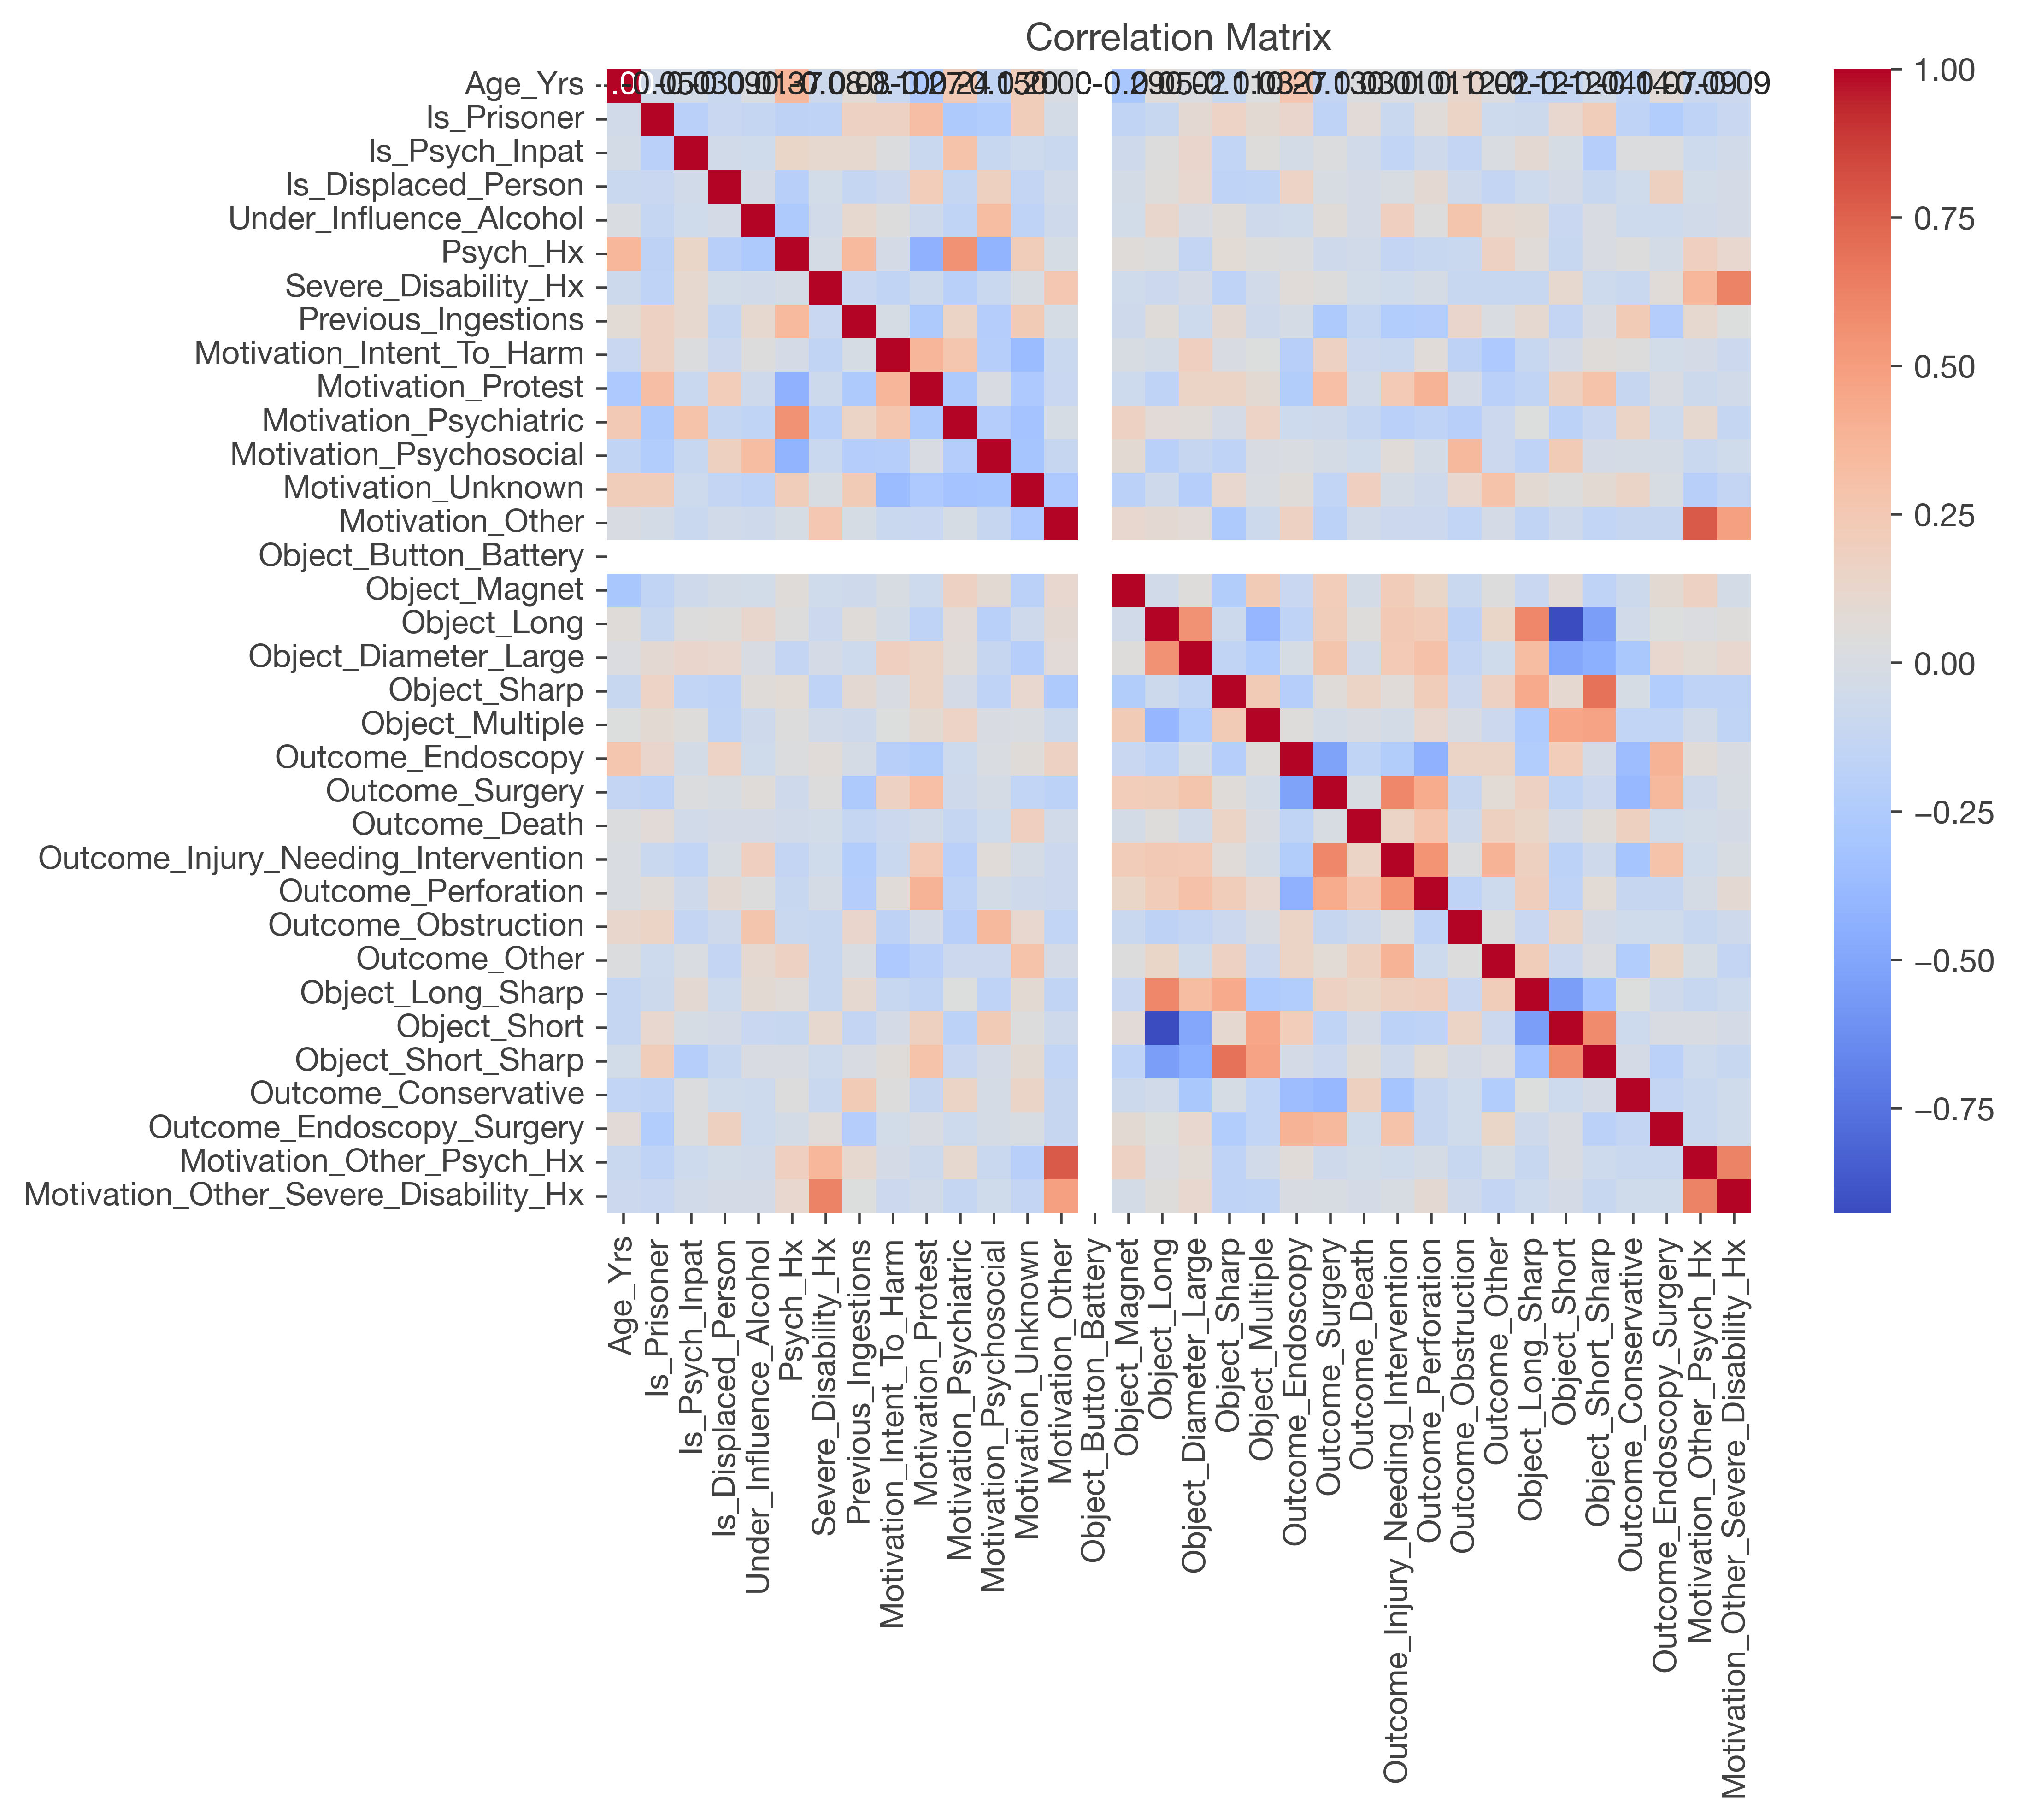

In [497]:
# Compute correlation matrix
corr = case_df.corr(numeric_only=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Correlation Matrix")
plt.tight_layout()

# Save figure
fig_path = os.path.join(figures_path, "correlation_matrix.png")
plt.savefig(fig_path, dpi=300)
plt.show()
plt.close()


In [498]:
# Step 1: Compute the correlation matrix
corr_matrix = case_df.corr(numeric_only=True)

# Step 2: Unstack to get all variable pairs
corr_pairs = corr_matrix.unstack()

# Step 3: Remove self-correlations
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]

# Step 4: Drop duplicate pairs (e.g., A-B and B-A)
corr_pairs = corr_pairs.drop_duplicates()

# Step 5: Sort by absolute correlation value (strongest first)
sorted_corr = corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)

# Step 6: Convert top 20 to DataFrame
top_corr_df = sorted_corr.head(30).reset_index()
top_corr_df.columns = ['Variable A', 'Variable B', 'Correlation']

# Step 7: Clean variable names (replace underscores with spaces)
top_corr_df['Variable A'] = top_corr_df['Variable A'].str.replace('_', ' ')
top_corr_df['Variable B'] = top_corr_df['Variable B'].str.replace('_', ' ')

# Step 8: Round correlation values for clarity
top_corr_df['Correlation'] = top_corr_df['Correlation'].round(3)

# Step 9: Convert to LaTeX
latex_table = top_corr_df.to_latex(
    index=False,
    caption=None,
    label=None,
    escape=True
)

# Wrap with a properly centered LaTeX table block
latex_wrapped = f"""
\\begin{{table}}[H]
\\centering
\\caption{{Top 30 strongest pairwise Pearson correlations between variables}}
\\label{{tab:top-correlations}}
{latex_table}
\\end{{table}}
\\FloatBarrier
"""

# Step 10: Define and create output path using os.path
tables_folder = os.path.join(output_path, "tables")
os.makedirs(tables_folder, exist_ok=True)
table_file = os.path.join(tables_folder, "top_correlations.tex")

# Step 11: Write LaTeX table to file
with open(table_file, "w") as f:
    f.write(latex_wrapped)

print(f"LaTeX table written to: {table_file}")
top_corr_df

LaTeX table written to: /Users/jackgedge/msc_dissertation/output/reports/data_extraction/tables/top_correlations.tex


,Variable A,Variable B,Correlation
0,Object Long,Object Short,-0.926
1,Motivation Other,Motivation Other Psych Hx,0.775
2,Object Sharp,Object Short Sharp,0.688
3,Severe Disability Hx,Motivation Other Severe Disability Hx,0.621
4,Object Long,Object Long Sharp,0.599
5,Outcome Surgery,Outcome Injury Needing Intervention,0.595
6,Object Short,Object Short Sharp,0.583
7,Object Long,Object Diameter Large,0.551
8,Psych Hx,Motivation Psychiatric,0.549
9,Outcome Injury Needing Intervention,Outcome Perforation,0.546


In [499]:
def calculate_rate_by_study(
    input_df,
    output_df,
    condition,
    study_col='Study_ID',
    id_col='Patient_ID',
    prefix='Outcome'
):
    """
    Calculates rate of a condition per study and merges it into output_df.
    
    Parameters:
        input_df (DataFrame): Raw case-level data.
        output_df (DataFrame): Paper-level data (e.g. one row per study).
        condition (Series[bool]): Boolean mask to filter input_df.
        study_col (str): Column in both dataframes that identifies the study.
        id_col (str): Column to count as individual cases.
        prefix (str): Prefix for naming output columns (e.g. 'Endoscopy' or '%_Is_Prisoner').

    Returns:
        DataFrame: Modified output_df with total cases, condition counts, and rate.
    """
    input_df = input_df.copy()
    input_df[study_col] = input_df[study_col].astype(str)
    output_df = output_df.copy()
    output_df[study_col] = output_df[study_col].astype(str)
    
    # Total cases per study
    total_counts = input_df.groupby(study_col)[id_col].count()
    
    # Cases matching the condition
    matching_counts = input_df[condition].groupby(study_col)[id_col].count()
    
    # Combine into summary DataFrame
    summary = pd.DataFrame({
        'Total_Cases': total_counts,
        f'{prefix}_Cases': matching_counts
    }).fillna(0)
    
    # Calculate rate
    summary[f'{prefix}_Rate'] = summary[f'{prefix}_Cases'] / summary['Total_Cases']
    
    # Merge into output_df
    output_df = output_df.drop(columns=['Total_Cases'], errors='ignore')
    output_df = output_df.merge(summary, on=study_col, how='left')
    
    # Fill in missing values
    output_df[['Total_Cases', f'{prefix}_Cases', f'{prefix}_Rate']] = output_df[[
        'Total_Cases', f'{prefix}_Cases', f'{prefix}_Rate'
    ]].fillna(0)
    
    return output_df

In [500]:
def calculate_age_summary_by_study(
    input_df,
    output_df,
    age_col='Age',
    study_col='Study_ID',
    id_col='Patient_ID',
    prefix='Age_Yrs'
):
    """
    Calculates summary stats (min, max, mean, median) for age per study and merges into output_df.

    Parameters:
        input_df (DataFrame): Case-level data.
        output_df (DataFrame): Paper-level data (1 row per study).
        age_col (str): Name of the column containing age data.
        study_col (str): Study identifier column (shared across both dataframes).
        id_col (str): Patient ID column, used only for grouping safety.
        prefix (str): Prefix for new column names.

    Returns:
        DataFrame: Updated output_df with Age_Low, Age_High, Age_Mean, Age_Median
    """
    input_df = input_df.copy()
    output_df = output_df.copy()

    input_df[study_col] = input_df[study_col].astype(str)
    output_df[study_col] = output_df[study_col].astype(str)

    # Ensure Age is numeric
    input_df[age_col] = pd.to_numeric(input_df[age_col], errors='coerce')

    # Group and calculate summary stats
    age_summary = input_df.groupby(study_col)[age_col].agg(
        Age_Low='min',
        Age_High='max',
        Age_Mean='mean',
        Age_Median='median'
    ).reset_index()

    # Merge into paper_data
    output_df = output_df.merge(age_summary, on=study_col, how='left')

    return output_df

In [501]:
def calculate_category_rates_by_study(
    input_df,
    output_df,
    category_col,
    categories,
    study_col='Study_ID',
    id_col='Patient_ID',
    prefix='Gender'
):
    """
    Calculates rate of each category value per study and merges them into output_df.

    Parameters:
        input_df (DataFrame): Raw case-level data.
        output_df (DataFrame): Paper-level data (one row per study).
        category_col (str): Column containing the category (e.g. 'Gender').
        categories (dict): Dictionary mapping raw values to desired column suffixes.
                           E.g., {'Male': 'Male', 'Female': 'Female', 'UK': 'Unknown'}
        study_col (str): Column name that identifies the study (default 'Study_ID').
        id_col (str): Column name that identifies unique patients (default 'Patient_ID').
        prefix (str): Prefix for the output column names.

    Returns:
        DataFrame: Updated output_df with category rates per study.
    """
    input_df = input_df.copy()
    output_df = output_df.copy()
    
    input_df[study_col] = input_df[study_col].astype(str)
    output_df[study_col] = output_df[study_col].astype(str)

    # Total cases per study
    total_counts = input_df.groupby(study_col)[id_col].count()

    # Start the summary DataFrame with total counts
    summary = pd.DataFrame({'Total_Cases': total_counts})

    # Loop through each category
    for raw_value, label in categories.items():
        cat_counts = input_df[input_df[category_col] == raw_value].groupby(study_col)[id_col].count()
        summary[f'{prefix}_{label}_Cases'] = cat_counts
        summary[f'{prefix}_{label}_Rate'] = (cat_counts / summary['Total_Cases'])

    # Fill any missing values with 0
    summary = summary.fillna(0)

    # Merge into output_df
    output_df = output_df.drop(columns=['Total_Cases'], errors='ignore')
    output_df = output_df.merge(summary, on=study_col, how='left')
    
    # Fill missing values (e.g., studies with no cases)
    cols_to_fill = ['Total_Cases'] + [f'{prefix}_{label}_{suffix}' for label in categories.values() for suffix in ['Cases', 'Rate']]
    output_df[cols_to_fill] = output_df[cols_to_fill].fillna(0)

    return output_df

In [502]:
population_cols

['Is_Prisoner',
 'Is_Psych_Inpat',
 'Is_Displaced_Person',
 'Under_Influence_Alcohol',
 'Psych_Hx',
 'Severe_Disability_Hx',
 'Previous_Ingestions']

In [503]:
agg_paper_df = paper_df.copy()

# Calculate age summary for each study
agg_paper_df = calculate_age_summary_by_study(
    input_df=case_df,
    output_df=agg_paper_df,
    age_col='Age_Yrs'
)

In [504]:
gender_map = {
    'Male': 'Male',
    'Female': 'Female',
    'Unknown': 'Unknown'
}

# Calculate gender category rates
agg_paper_df = calculate_category_rates_by_study(
    input_df=case_df,
    output_df=agg_paper_df,
    category_col='Gender',
    categories=gender_map,
    prefix='Gender'
)

In [505]:
for col in population_cols:
    agg_paper_df = calculate_rate_by_study(
        input_df=case_df, 
        output_df=agg_paper_df, 
        condition=case_df[col] == 1,
        prefix=col
    )

for col in motivation_cols:
    agg_paper_df = calculate_rate_by_study(
    input_df=case_df, 
    output_df=agg_paper_df, 
    condition=case_df[col] == 1,
    prefix=col
)

for col in object_cols:
    agg_paper_df = calculate_rate_by_study(
    input_df=case_df, 
    output_df=agg_paper_df, 
    condition=case_df[col] == 1,
    prefix=col
)

for col in outcome_cols:
    agg_paper_df = calculate_rate_by_study(
    input_df=case_df, 
    output_df=agg_paper_df, 
    condition=case_df[col] == 1,
    prefix=col
)


In [506]:
agg_paper_df.columns

Index(['Study_ID', 'First_Author', 'Publication_Year', 'Authors',
       'Publication_Title', 'Title', 'Study_Design', 'Study_Setting',
       'Study_Location', 'DOI', 'Data_Extracted', 'Bibliography_Searched',
       'Exclude', 'Notes', 'Case_Count', 'Age_Low', 'Age_High', 'Age_Mean',
       'Age_Median', 'Gender_Male_Cases', 'Gender_Male_Rate',
       'Gender_Female_Cases', 'Gender_Female_Rate', 'Gender_Unknown_Cases',
       'Gender_Unknown_Rate', 'Is_Prisoner_Cases', 'Is_Prisoner_Rate',
       'Is_Psych_Inpat_Cases', 'Is_Psych_Inpat_Rate',
       'Is_Displaced_Person_Cases', 'Is_Displaced_Person_Rate',
       'Under_Influence_Alcohol_Cases', 'Under_Influence_Alcohol_Rate',
       'Psych_Hx_Cases', 'Psych_Hx_Rate', 'Severe_Disability_Hx_Cases',
       'Severe_Disability_Hx_Rate', 'Previous_Ingestions_Cases',
       'Previous_Ingestions_Rate', 'Motivation_Intent_To_Harm_Cases',
       'Motivation_Intent_To_Harm_Rate', 'Motivation_Protest_Cases',
       'Motivation_Protest_Rate', 'Mot

In [507]:
aggregate_paper_data_path = os.path.join(PROC_DATA_DIR, "data_extraction", "aggregate_paper_data.csv")
agg_paper_df.to_csv(aggregate_paper_data_path)

In [508]:
processed_case_data_path = os.path.join(os.path.join(PROC_DATA_DIR, "data_extraction", "processed_case_data.csv"))
proc_case_df = case_df
proc_case_df.to_csv(processed_case_data_path)